In [1]:
from glob import glob

%matplotlib inline
from pylab import *
# import cv2
import rasterio as rio

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

import rasterio

# add the unet helpers
sys.path.append('../../')
from test_unet_helpers import *
from unet_models import unet11_MS

# torch stuff
import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models, datasets
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expe

In [2]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

from glob import glob
class DG_GT_Dataset(Dataset):
    """Dataset class DG and GT data"""
    
    def __init__(self, data_dir, channels='all', img_transform=None, gt_transform=None, rot=False):
        """ 
        Args:
            data_dir (string): the folder containing the image files
            channels (string): 'all', 'bgr', 'bgrn1', 'bgrn2'; band sets for DG imagery
            img_transform (callable, optional): Optional transform to  be applied to source image data
            gt_transform (callable, optional): Optional transform to  be applied to labeled image data
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        
        self.gt_files = sorted(glob(data_dir + '/gt*.tif'))
        self.img_files = sorted(glob(data_dir + '/dg*.tif'))
        
        
        print(self.img_files[0])
        print(self.gt_files[0])
        
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.dg_bgr = [1,2,4]
        self.dg_bgrn1 = [1,2,4,6]
        self.dg_bgrn2 = [1,2,4,7]
        self.channels = channels
        self.rot = rot
        
        assert len(self.img_files) == len(self.gt_files)
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        img_file = self.img_files[idx]
        gt_file = self.gt_files[idx]
        
        with rio.open(img_file) as src:
            img_arr = src.read()
            
        # check the channels
        if self.channels == 'bgr':
            img_arr = img_arr[self.dg_bgr, :, :]
        elif self.channels == 'bgrn1':
            img_arr = img_arr[self.dg_bgrn1, :, :]
        elif self.channels == 'bgrn2':
            img_arr = img_arr[self.dg_brgn2, :, :]
        else:
            pass
            
        with rio.open(gt_file) as src:
            gt_arr = src.read()
            
        #print(img_arr.shape, gt_arr.shape)

        # first consider the rotation argument
        if self.rot:
            dg_t = torch.from_numpy(img_arr)
            gt_t = torch.from_numpy(gt_arr)
            
            # get a random number
            rot_p = np.random.random()*100
            if rot_p < 35:
                
                dg_rot = dg_t.transpose(1,2)
                gt_rot = gt_t.transpose(1,2)
                
                return (dg_rot, gt_t)
            
            elif (rot_p >= 35) and (rot_p < 75):
                
                dg_rot = dg_t.flip(1).flip(2)
                gt_rot = gt_t.flip(1).flip(2)
                
                return (dg_rot, gt_rot)
                
            else:
            
                dg_rot = dg_t.transpose(1,2).flip(2) #t90 CCW
                gt_rot = gt_t.transpose(1,2).flip(2)
                
                return(dg_rot, gt_rot)
            


        if (self.img_transform is not None):
            return (self.img_transform(torch.from_numpy(img_arr)), 
                    self.gt_transform(torch.from_numpy(gt_arr)))   
        else:
            return (torch.from_numpy(img_arr), torch.from_numpy(gt_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
            
        
    def __len__(self):
        return len(self.img_files)

# Now that data is ready, set up the model and run through it

## some code for saving the model

In [3]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

## some code for setting up the model and performance eval

In [4]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = False

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# DO the same for pansharpened data

In [5]:
train_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\train'
test_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\test'
val_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\val'

# ubuntu paths
train_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/val'

# aws pathts
train_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/val'

# load as 4 band
ps_train_ds = DG_GT_Dataset(train_folder, channels='bgrn1')
ps_train_ds_rot = DG_GT_Dataset(train_folder, channels='bgrn1', rot=True)

ps_test_ds = DG_GT_Dataset(test_folder, channels='bgrn1')
ps_val_ds = DG_GT_Dataset(val_folder, channels='bgrn1')

../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/test/dg_is_00731.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/test/gt_is_00731.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/val/dg_is_00500.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/val/gt_is_00500.tif


In [6]:
# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
# smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
#model = unet11_MS(num_bands=4, pretrained=False)

# set some parameters
lr = 0.001
bsize = 32 # was 32

#ps_model = UNet(in_channels=4, n_classes=1, depth=5, wf=6, padding=True, batch_norm=False, up_mode='upconv')
ps_model = unet11_MS(num_bands=4, pretrained=False)

ps_optimizer = Adam(ps_model.parameters(), lr=lr)
ps_criterion = LossBinary(jaccard_weight=1.0)

###### specify DataLoaders
n_workers=4 # for some unknown reason, 0 is enabling all GPUs when 4 had previously done the trick. could be slower.
ps_train_dl = DataLoader(ps_train_ds, batch_size=bsize, shuffle=True, num_workers=n_workers)
ps_train_rot_dl = DataLoader(ps_train_ds_rot, batch_size=bsize, shuffle=True, num_workers=n_workers)
ps_test_dl = DataLoader(ps_test_ds, batch_size=bsize, shuffle=True, num_workers=n_workers)


# make model parallel and on GPU
# device=torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() >= 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    ps_model = nn.DataParallel(ps_model)
    ps_model.to(device)

num_bands is  4
Let's use 4 GPUs!


In [7]:
device

device(type='cuda')

In [8]:
print('batchsize, ', bsize)
ps_mean_loss = 0.0
ps_running_loss = 0.0
print('training...')

ps_losses=[]
ps_losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
ps_step=0
# record time for one epoch
ps_rocs = []

#####################################################

t0 = time.time()
num_epochs = 500
for epoch in range(num_epochs):
    
#     try:
    te = time.time()

    epoch_i = epoch+1
    print('on epoch {}'.format(epoch_i))

    running_loss = 0
    for dl in (ps_train_dl, ps_train_rot_dl): # added rotated training dataset
        for i, (inputs_, targets_) in enumerate(dl):

            #print('hi')

            # get the inputs
            targets_ = targets_.type(torch.FloatTensor)

            #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
            inputs, targets = variable(inputs_), variable(targets_)
            inputs.to(device)
            targets.to(device)

            outputs = ps_model(inputs)

            # zero parameter gradients
            ps_optimizer.zero_grad()

            # forward + backward + optimize            
            i_loss = ps_criterion(outputs, targets)                
            i_loss.backward()
            ps_optimizer.step()
            ps_step+=1

            running_loss += i_loss

            if i%5 == 0: # print/store every 10
                ps_losses.append(i_loss)
                #running_loss += i_loss
                #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))

        # get some numbers for the ROC curve
        if epoch_i%2 == 0:
            pred_y = outputs.cpu().data.numpy().squeeze().flatten()
            target_y = targets.cpu().data.numpy().flatten()
            tu = (i_loss, roc_auc_score(target_y,pred_y ))
            print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  
            ps_rocs.append(tu[1])


        ps_losses_ep.append(running_loss)
        te1 = time.time()
        print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))

        # early exit critera
        if len(ps_rocs)>2:
            if (np.abs(ps_rocs[-1] - ps_rocs[-2]) < 0.009) and (ps_rocs[-1] > 0.98):
                print('area under curve not changing significantly, exit loop')
                break_flag = False

                if break_flag:
                    break

    #     except Exception as e:
    #         print('something happened')
    #         print(e)
    #         break

        
t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

batchsize,  32
training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 1: 13.41893458366394 seconds
time for epoch 1: 16.90353226661682 seconds
on epoch 2
epoch: 2, LOSS=1.1414752006530762, ROC_AUC=0.7632050603777403 
time for epoch 2: 3.9246087074279785 seconds
epoch: 2, LOSS=1.1090142726898193, ROC_AUC=0.7262132180380777 
time for epoch 2: 7.760778427124023 seconds
on epoch 3
time for epoch 3: 3.3304052352905273 seconds
time for epoch 3: 6.8552796840667725 seconds
on epoch 4
epoch: 4, LOSS=1.1309715509414673, ROC_AUC=0.7831291159966045 
time for epoch 4: 4.092530965805054 seconds
epoch: 4, LOSS=1.292264461517334, ROC_AUC=0.6874300273542662 
time for epoch 4: 8.121037244796753 seconds
on epoch 5
time for epoch 5: 3.2735321521759033 seconds
time for epoch 5: 6.787273168563843 seconds
on epoch 6
epoch: 6, LOSS=1.1555817127227783, ROC_AUC=0.7815878928432002 
time for epoch 6: 3.943368673324585 seconds
epoch: 6, LOSS=1.1858186721801758, ROC_AUC=0.7136405034378169 
time for epoch 6: 7.7494518756866455 seconds
on epoch 7
time for epoch 7: 3.3119

time for epoch 51: 3.362865924835205 seconds
time for epoch 51: 6.949559211730957 seconds
on epoch 52
epoch: 52, LOSS=0.8988808393478394, ROC_AUC=0.8670793049391198 
time for epoch 52: 3.913851261138916 seconds
epoch: 52, LOSS=1.0951422452926636, ROC_AUC=0.7299746334759142 
time for epoch 52: 7.805927038192749 seconds
on epoch 53
time for epoch 53: 3.4463329315185547 seconds
time for epoch 53: 6.997301340103149 seconds
on epoch 54
epoch: 54, LOSS=0.8047795295715332, ROC_AUC=0.8591200096682182 
time for epoch 54: 3.8759522438049316 seconds
epoch: 54, LOSS=1.2855011224746704, ROC_AUC=0.6798754883023239 
time for epoch 54: 7.8983447551727295 seconds
on epoch 55
time for epoch 55: 3.326587200164795 seconds
time for epoch 55: 6.913719654083252 seconds
on epoch 56
epoch: 56, LOSS=0.8225162029266357, ROC_AUC=0.8801505084468763 
time for epoch 56: 3.9436042308807373 seconds
epoch: 56, LOSS=1.2638587951660156, ROC_AUC=0.7069494810165513 
time for epoch 56: 8.046648979187012 seconds
on epoch 57


time for epoch 101: 3.354931354522705 seconds
time for epoch 101: 6.936553716659546 seconds
on epoch 102
epoch: 102, LOSS=0.8958173394203186, ROC_AUC=0.874133709138508 
time for epoch 102: 4.215473890304565 seconds
epoch: 102, LOSS=1.1235637664794922, ROC_AUC=0.7105578341558253 
time for epoch 102: 8.284904956817627 seconds
on epoch 103
time for epoch 103: 3.30717396736145 seconds
time for epoch 103: 6.915361166000366 seconds
on epoch 104
epoch: 104, LOSS=0.8790713548660278, ROC_AUC=0.8642869208085702 
time for epoch 104: 4.184617519378662 seconds
epoch: 104, LOSS=1.2404310703277588, ROC_AUC=0.7059399548915223 
time for epoch 104: 8.303065538406372 seconds
on epoch 105
time for epoch 105: 3.3457443714141846 seconds
time for epoch 105: 6.944020986557007 seconds
on epoch 106
epoch: 106, LOSS=0.9052566885948181, ROC_AUC=0.8628054471135532 
time for epoch 106: 3.9296388626098633 seconds
epoch: 106, LOSS=1.168818473815918, ROC_AUC=0.7313179572090723 
time for epoch 106: 7.843670129776001 se

time for epoch 149: 7.139004468917847 seconds
on epoch 150
epoch: 150, LOSS=0.8255394697189331, ROC_AUC=0.8683515707149569 
time for epoch 150: 4.166823625564575 seconds
epoch: 150, LOSS=1.3420084714889526, ROC_AUC=0.6814946228975713 
time for epoch 150: 8.148421287536621 seconds
on epoch 151
time for epoch 151: 3.3859803676605225 seconds
time for epoch 151: 7.24739146232605 seconds
on epoch 152
epoch: 152, LOSS=0.9096572399139404, ROC_AUC=0.8585565581789227 
time for epoch 152: 4.1181135177612305 seconds
epoch: 152, LOSS=1.323347568511963, ROC_AUC=0.6877575497775288 
time for epoch 152: 8.065086841583252 seconds
on epoch 153
time for epoch 153: 3.329371929168701 seconds
time for epoch 153: 7.18379020690918 seconds
on epoch 154
epoch: 154, LOSS=0.8832472562789917, ROC_AUC=0.8761594420331749 
time for epoch 154: 3.9707744121551514 seconds
epoch: 154, LOSS=1.1793620586395264, ROC_AUC=0.7121382803290282 
time for epoch 154: 7.913483381271362 seconds
on epoch 155
time for epoch 155: 3.4706

epoch: 198, LOSS=0.7829681634902954, ROC_AUC=0.8973291512496704 
time for epoch 198: 4.293277263641357 seconds
epoch: 198, LOSS=1.1602704524993896, ROC_AUC=0.7201376040742659 
time for epoch 198: 8.44123125076294 seconds
on epoch 199
time for epoch 199: 3.4978792667388916 seconds
time for epoch 199: 7.372877597808838 seconds
on epoch 200
epoch: 200, LOSS=0.830065131187439, ROC_AUC=0.8868934143164122 
time for epoch 200: 4.123960494995117 seconds
epoch: 200, LOSS=1.2115873098373413, ROC_AUC=0.7279850264039815 
time for epoch 200: 8.252220869064331 seconds
on epoch 201
time for epoch 201: 3.523960828781128 seconds
time for epoch 201: 7.201590299606323 seconds
on epoch 202
epoch: 202, LOSS=0.7424551844596863, ROC_AUC=0.9087675276998634 
time for epoch 202: 3.903707265853882 seconds
epoch: 202, LOSS=1.2417585849761963, ROC_AUC=0.717430082545002 
time for epoch 202: 7.917985916137695 seconds
on epoch 203
time for epoch 203: 3.4758460521698 seconds
time for epoch 203: 7.136369943618774 secon

epoch: 246, LOSS=0.9879773855209351, ROC_AUC=0.8052194191782669 
time for epoch 246: 8.420926332473755 seconds
on epoch 247
time for epoch 247: 3.3955702781677246 seconds
time for epoch 247: 6.899733781814575 seconds
on epoch 248
epoch: 248, LOSS=0.5415377020835876, ROC_AUC=0.9421485553319888 
time for epoch 248: 3.9871714115142822 seconds
epoch: 248, LOSS=1.01095449924469, ROC_AUC=0.8063737653120623 
time for epoch 248: 8.13178014755249 seconds
on epoch 249
time for epoch 249: 3.400845527648926 seconds
time for epoch 249: 7.304884433746338 seconds
on epoch 250
epoch: 250, LOSS=0.5137926340103149, ROC_AUC=0.9509157301790463 
time for epoch 250: 3.803220748901367 seconds
epoch: 250, LOSS=0.9678914546966553, ROC_AUC=0.8208794695517265 
time for epoch 250: 8.22222375869751 seconds
on epoch 251
time for epoch 251: 3.4166617393493652 seconds
time for epoch 251: 7.11303448677063 seconds
on epoch 252
epoch: 252, LOSS=0.6669774651527405, ROC_AUC=0.9283959451062578 
time for epoch 252: 4.175507

time for epoch 295: 3.4464194774627686 seconds
time for epoch 295: 7.391342639923096 seconds
on epoch 296
epoch: 296, LOSS=0.23704247176647186, ROC_AUC=0.9897408259924692 
time for epoch 296: 4.187695264816284 seconds
epoch: 296, LOSS=0.6777071952819824, ROC_AUC=0.9236413492671282 
time for epoch 296: 8.20221996307373 seconds
on epoch 297
time for epoch 297: 3.3882856369018555 seconds
time for epoch 297: 6.91275691986084 seconds
on epoch 298
epoch: 298, LOSS=0.21468517184257507, ROC_AUC=0.9910190350451267 
time for epoch 298: 4.1913957595825195 seconds
epoch: 298, LOSS=0.6694470643997192, ROC_AUC=0.9226487281039683 
time for epoch 298: 8.137503147125244 seconds
on epoch 299
time for epoch 299: 3.4202327728271484 seconds
time for epoch 299: 7.388522148132324 seconds
on epoch 300
epoch: 300, LOSS=0.22107988595962524, ROC_AUC=0.9912729875358183 
time for epoch 300: 4.051246166229248 seconds
epoch: 300, LOSS=0.7582411766052246, ROC_AUC=0.9058678987083126 
time for epoch 300: 8.074404001235

time for epoch 343: 7.321343898773193 seconds
on epoch 344
epoch: 344, LOSS=0.17331571877002716, ROC_AUC=0.9944948667729714 
time for epoch 344: 3.826779842376709 seconds
epoch: 344, LOSS=0.4711593985557556, ROC_AUC=0.960023186153301 
time for epoch 344: 7.985976934432983 seconds
on epoch 345
time for epoch 345: 3.4073538780212402 seconds
time for epoch 345: 7.388213634490967 seconds
on epoch 346
epoch: 346, LOSS=0.1447456181049347, ROC_AUC=0.9956194463872187 
time for epoch 346: 4.062432289123535 seconds
epoch: 346, LOSS=0.5255653262138367, ROC_AUC=0.9562311150864145 
time for epoch 346: 8.293301343917847 seconds
on epoch 347
time for epoch 347: 3.417637825012207 seconds
time for epoch 347: 7.368011474609375 seconds
on epoch 348
epoch: 348, LOSS=0.15006640553474426, ROC_AUC=0.9956222684700924 
time for epoch 348: 4.039281606674194 seconds
epoch: 348, LOSS=0.38350099325180054, ROC_AUC=0.9744682550497076 
time for epoch 348: 8.02989935874939 seconds
on epoch 349
time for epoch 349: 3.42

time for epoch 391: 3.5759434700012207 seconds
time for epoch 391: 7.366874694824219 seconds
on epoch 392
epoch: 392, LOSS=0.110615074634552, ROC_AUC=0.997738376050728 
time for epoch 392: 4.233254909515381 seconds
epoch: 392, LOSS=0.329012930393219, ROC_AUC=0.9810937967155895 
time for epoch 392: 8.391549348831177 seconds
on epoch 393
time for epoch 393: 3.468926429748535 seconds
time for epoch 393: 7.444649696350098 seconds
on epoch 394
epoch: 394, LOSS=0.1004629135131836, ROC_AUC=0.9979467452874635 
time for epoch 394: 4.1058571338653564 seconds
epoch: 394, LOSS=0.37526941299438477, ROC_AUC=0.9767665013130296 
time for epoch 394: 8.14775276184082 seconds
on epoch 395
time for epoch 395: 3.45767879486084 seconds
time for epoch 395: 7.220781087875366 seconds
on epoch 396
epoch: 396, LOSS=0.08682659268379211, ROC_AUC=0.9984157601130556 
time for epoch 396: 4.358860731124878 seconds
epoch: 396, LOSS=0.3303082585334778, ROC_AUC=0.9804376502320651 
time for epoch 396: 8.509940147399902 se

time for epoch 439: 7.650105237960815 seconds
on epoch 440
epoch: 440, LOSS=0.08869241178035736, ROC_AUC=0.9985776862767093 
time for epoch 440: 4.14026141166687 seconds
epoch: 440, LOSS=0.24912136793136597, ROC_AUC=0.9879438845209206 
time for epoch 440: 8.196758270263672 seconds
on epoch 441
time for epoch 441: 3.5876624584198 seconds
time for epoch 441: 7.1653852462768555 seconds
on epoch 442
epoch: 442, LOSS=0.0727272555232048, ROC_AUC=0.999005470525236 
time for epoch 442: 3.997445821762085 seconds
epoch: 442, LOSS=0.24359239637851715, ROC_AUC=0.9877230035726904 
time for epoch 442: 8.010891199111938 seconds
on epoch 443
time for epoch 443: 3.553440809249878 seconds
time for epoch 443: 7.564749240875244 seconds
on epoch 444
epoch: 444, LOSS=0.08708108961582184, ROC_AUC=0.9984693548234802 
time for epoch 444: 4.102873802185059 seconds
epoch: 444, LOSS=0.32169634103775024, ROC_AUC=0.9822852605164015 
time for epoch 444: 8.131922721862793 seconds
on epoch 445
time for epoch 445: 3.46

time for epoch 485: 3.480762481689453 seconds
time for epoch 485: 7.351290702819824 seconds
on epoch 486
epoch: 486, LOSS=0.07313865423202515, ROC_AUC=0.9989770045849335 
time for epoch 486: 4.400442123413086 seconds
epoch: 486, LOSS=0.2567150592803955, ROC_AUC=0.9882680595756316 
time for epoch 486: 8.639672756195068 seconds
on epoch 487
time for epoch 487: 3.5291450023651123 seconds
time for epoch 487: 7.363684415817261 seconds
on epoch 488
epoch: 488, LOSS=0.08398576080799103, ROC_AUC=0.9986466126544429 
time for epoch 488: 4.310147047042847 seconds
epoch: 488, LOSS=0.20043279230594635, ROC_AUC=0.9916955649308447 
time for epoch 488: 8.629632472991943 seconds
area under curve not changing significantly, exit loop
on epoch 489
time for epoch 489: 3.4960711002349854 seconds
area under curve not changing significantly, exit loop
time for epoch 489: 7.356472492218018 seconds
area under curve not changing significantly, exit loop
on epoch 490
epoch: 490, LOSS=0.06235635653138161, ROC_AUC

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


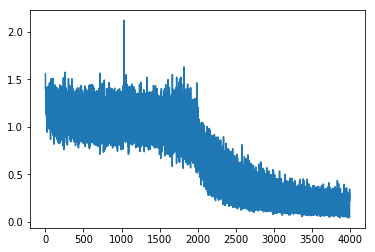

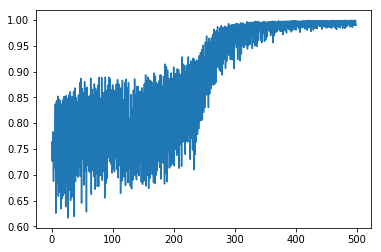

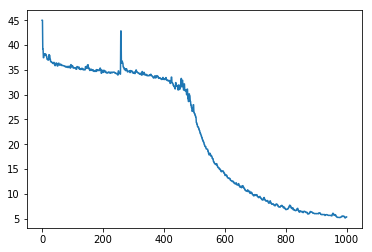

In [9]:
plt.plot(ps_losses)
plt.show()

plt.plot(ps_rocs)
plt.show()

plt.plot(ps_losses_ep)
plt.show()


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


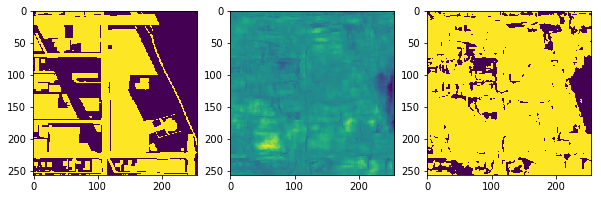

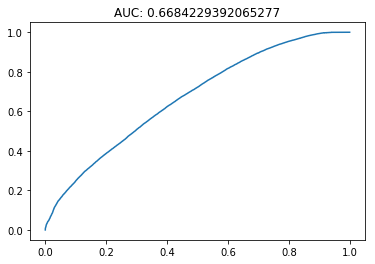

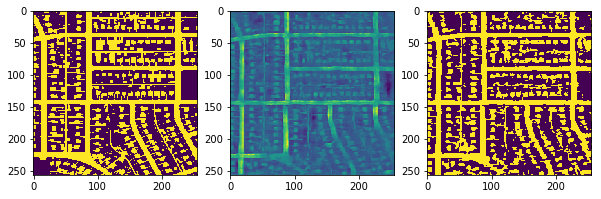

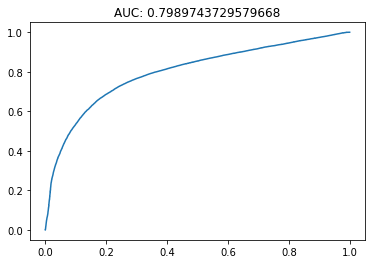

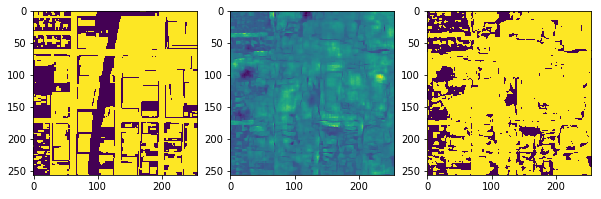

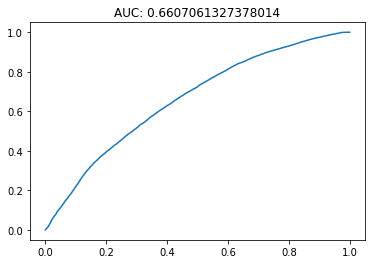

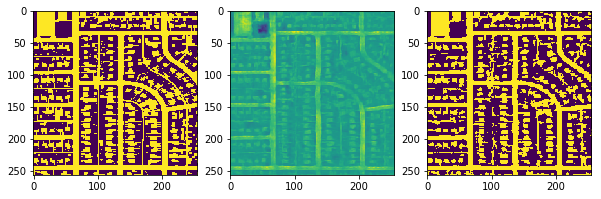

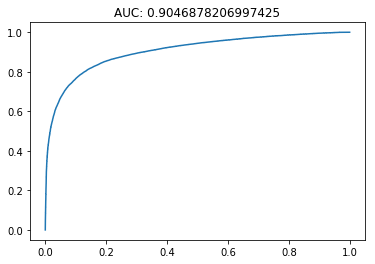

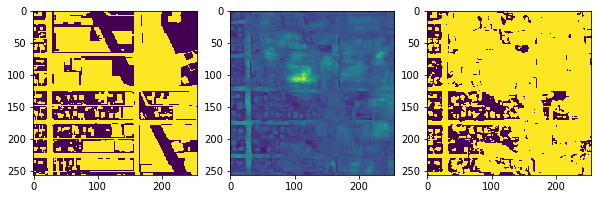

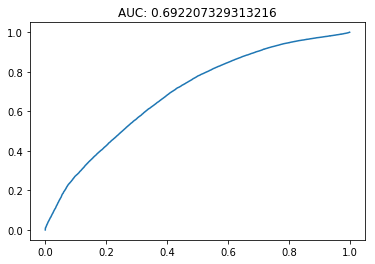

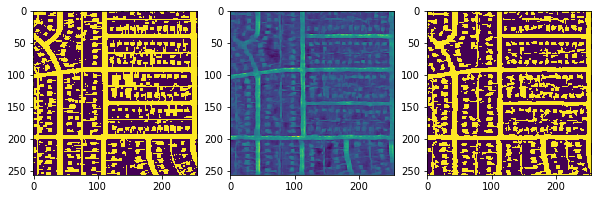

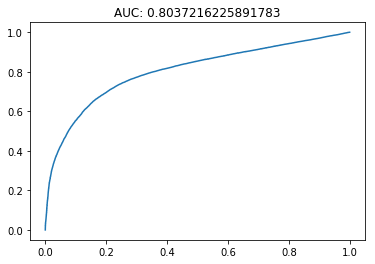

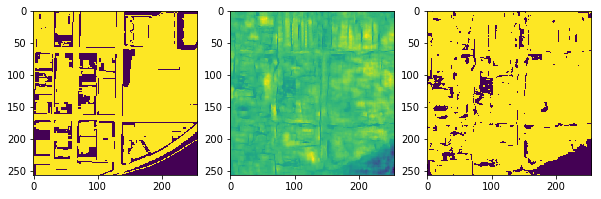

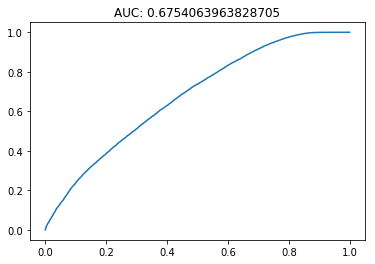

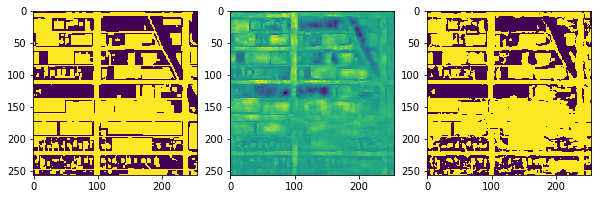

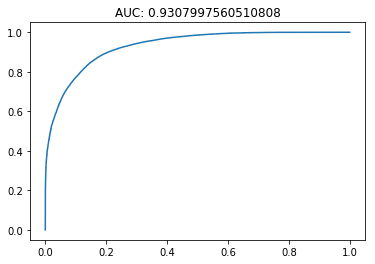

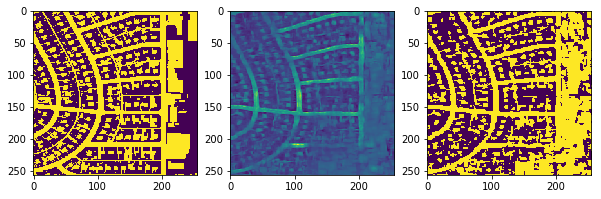

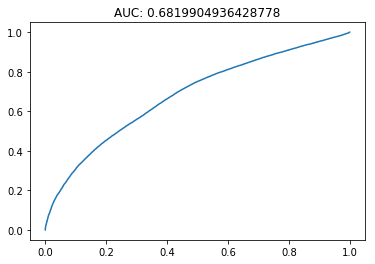

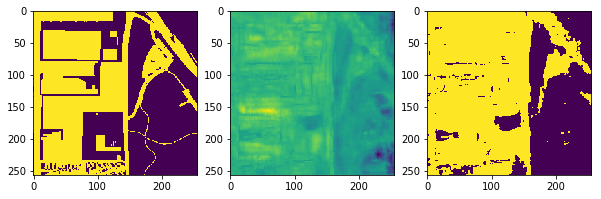

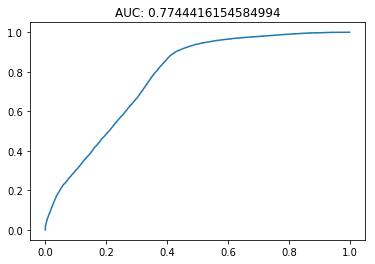

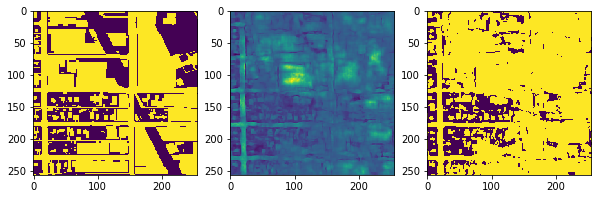

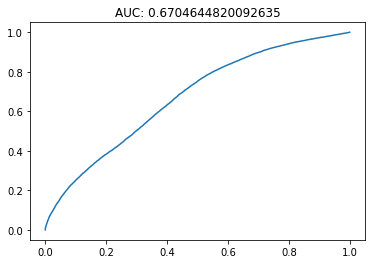

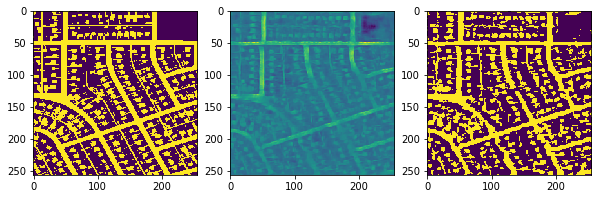

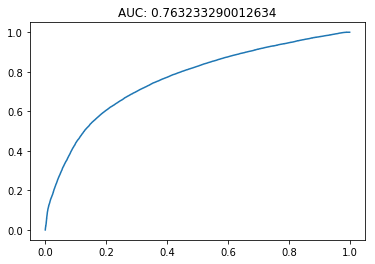

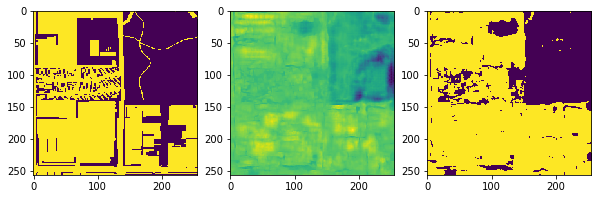

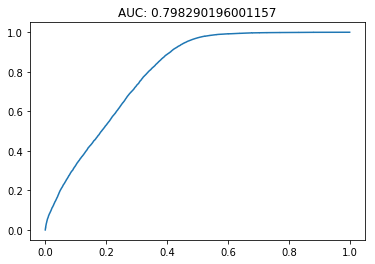

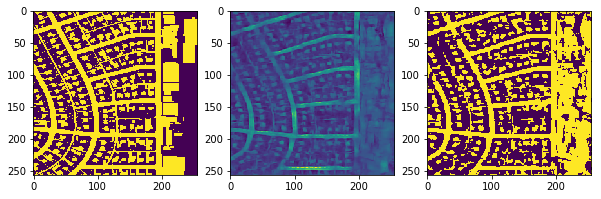

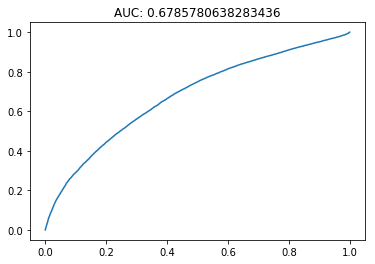

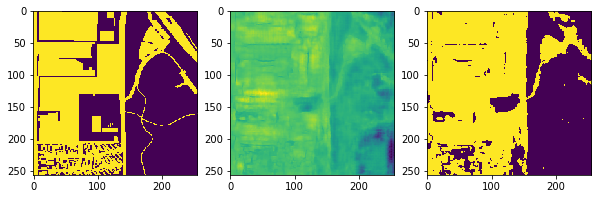

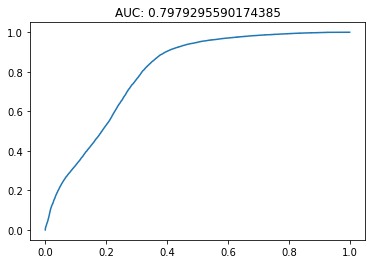

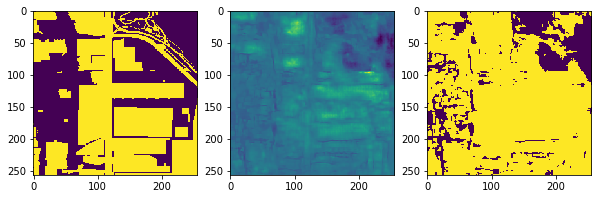

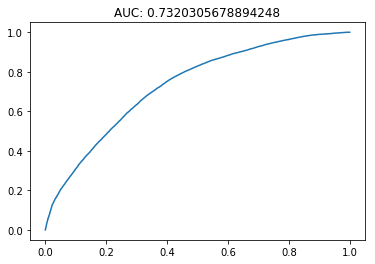

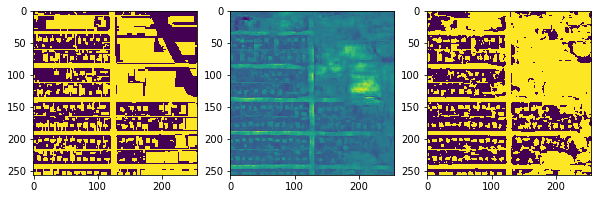

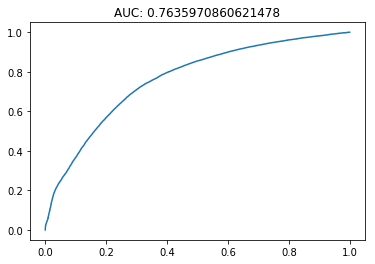

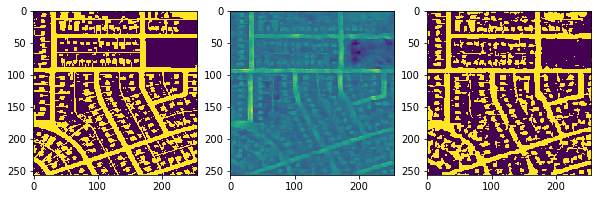

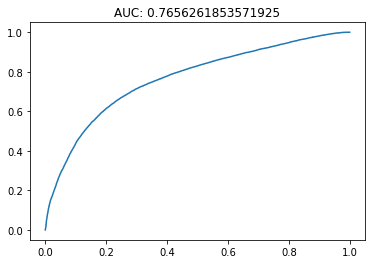

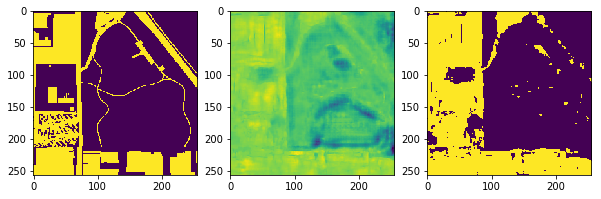

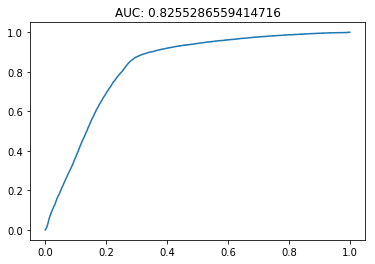

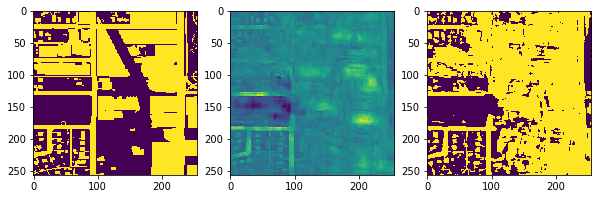

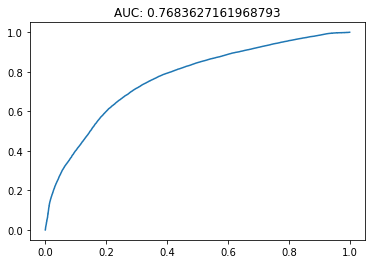

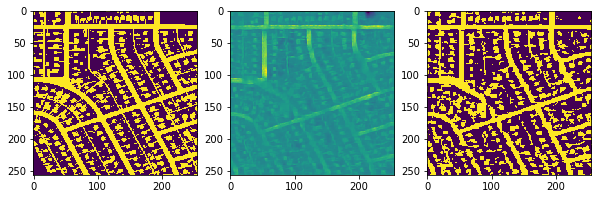

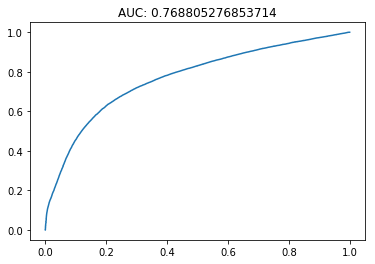

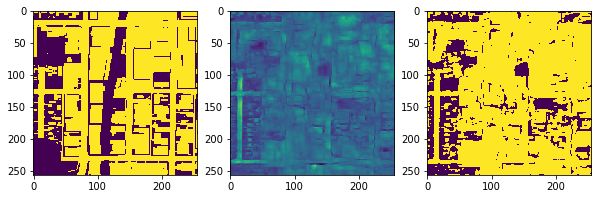

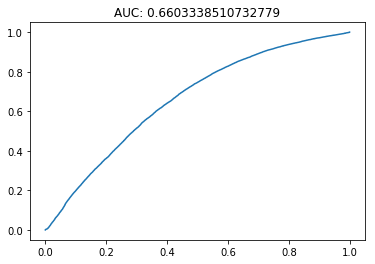

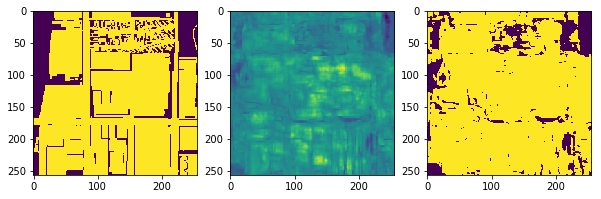

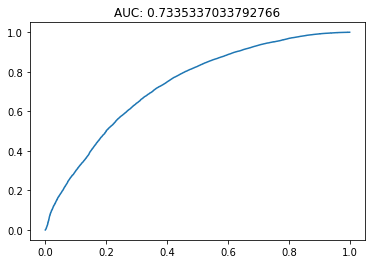

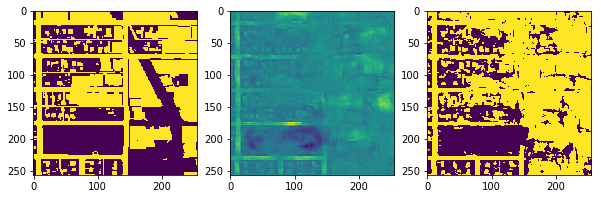

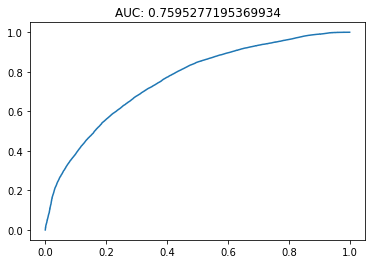

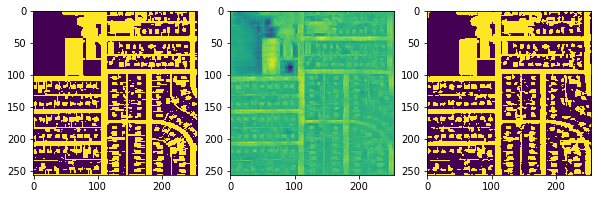

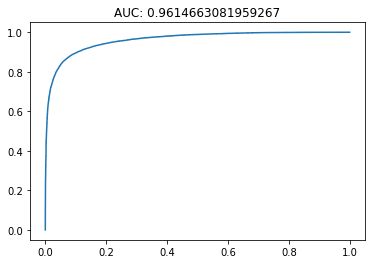

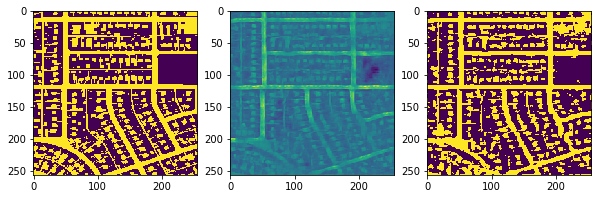

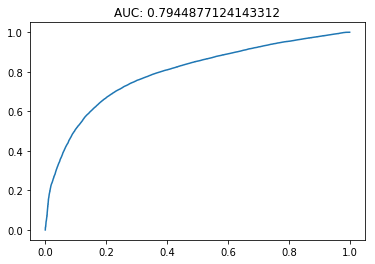

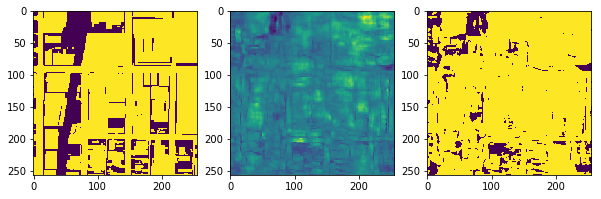

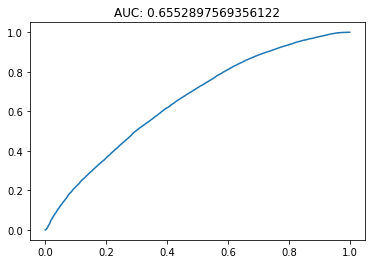

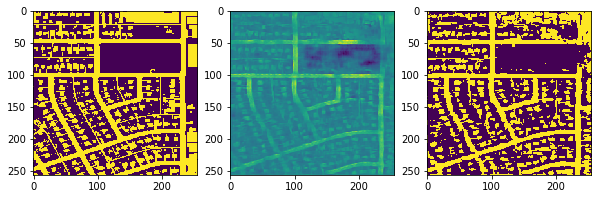

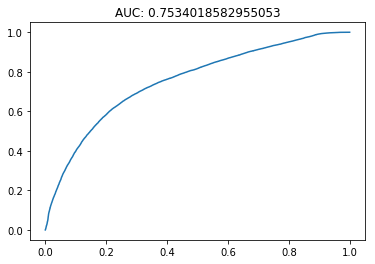

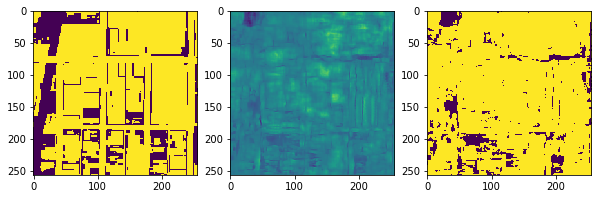

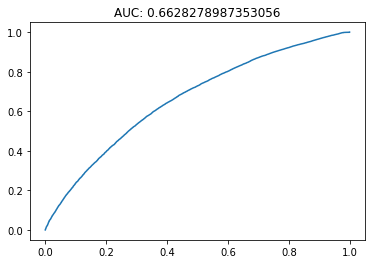

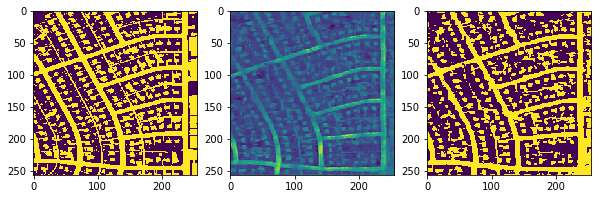

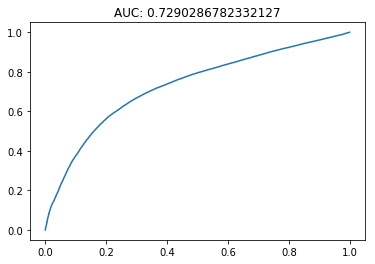

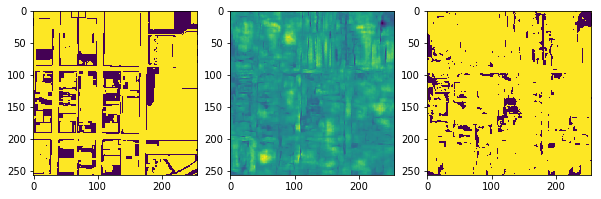

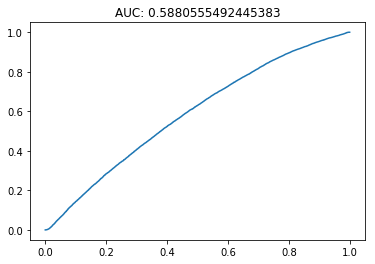

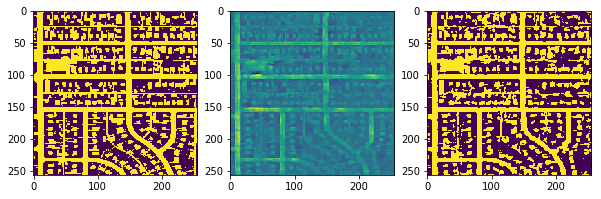

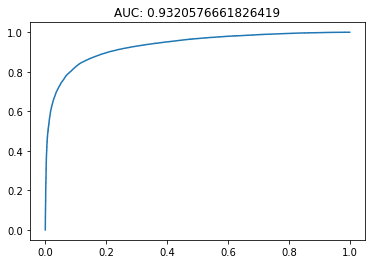

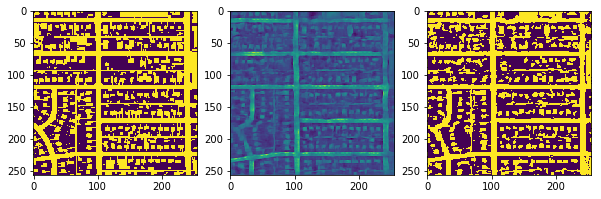

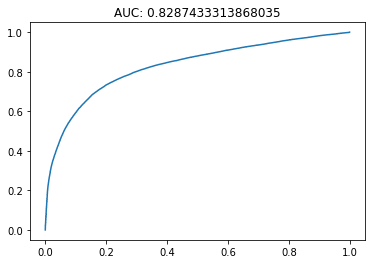

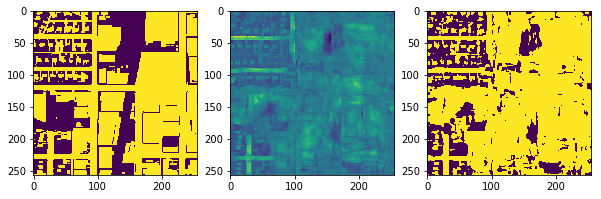

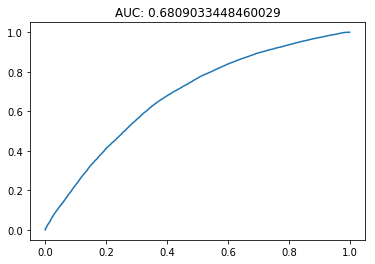

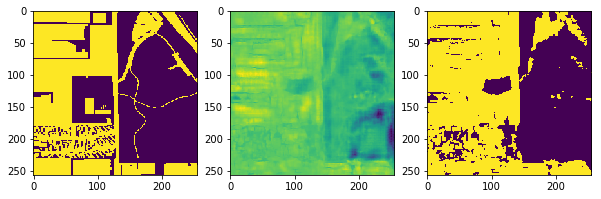

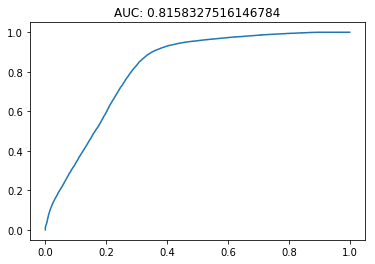

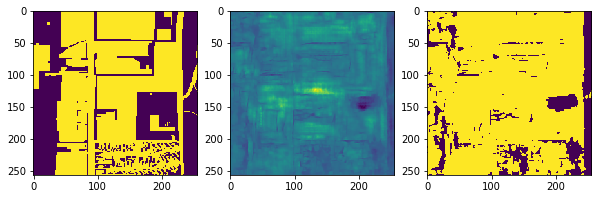

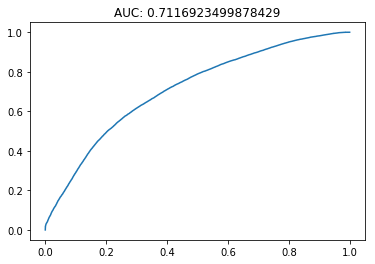

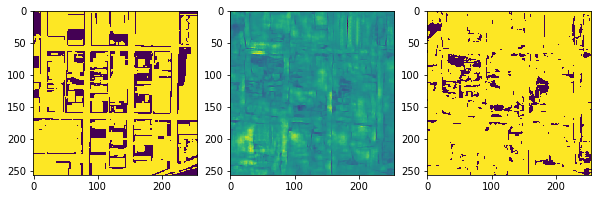

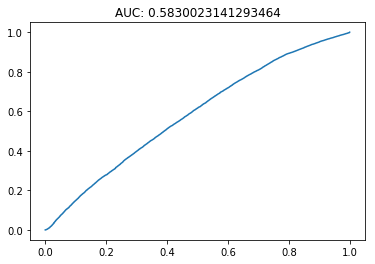

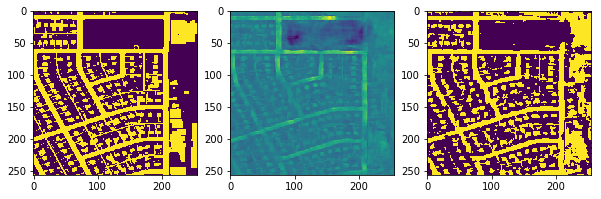

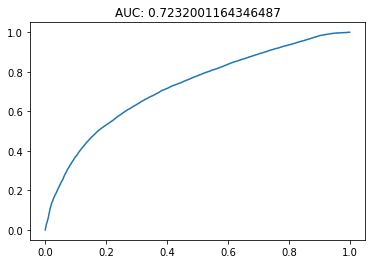

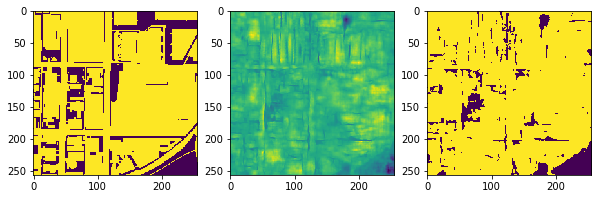

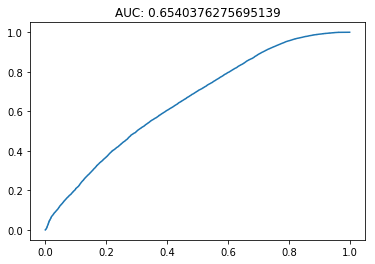

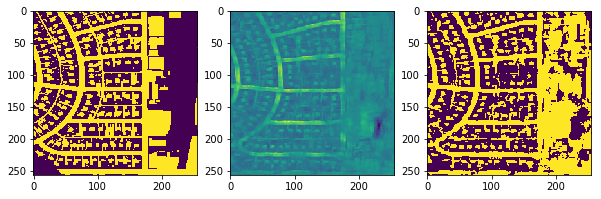

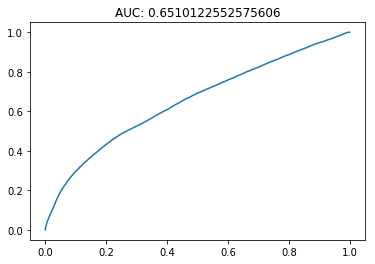

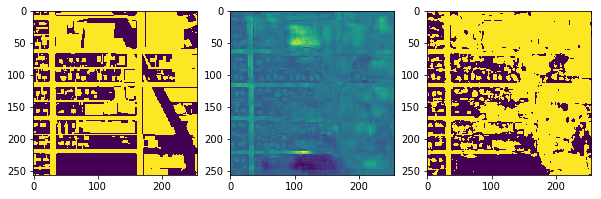

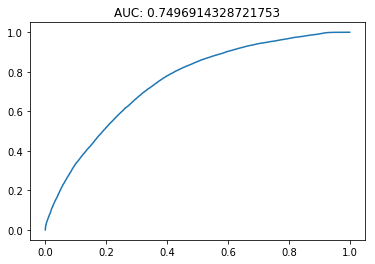

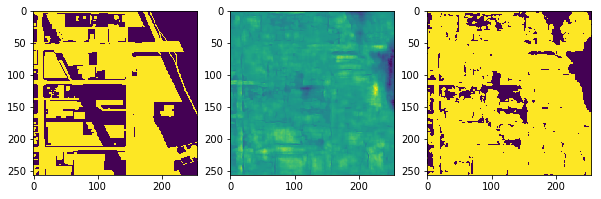

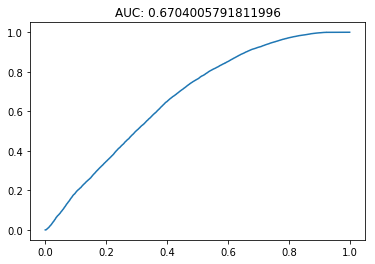

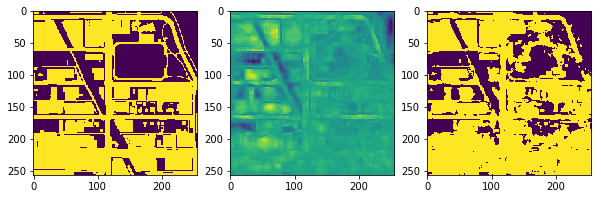

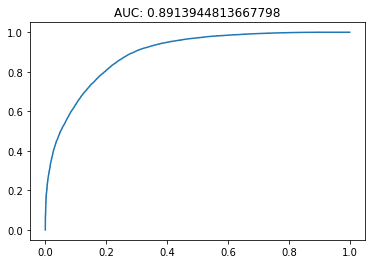

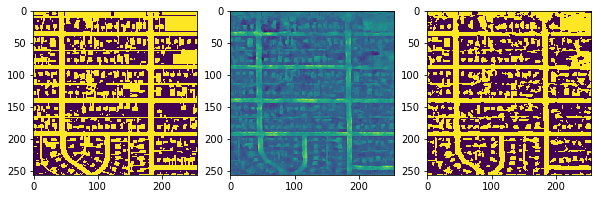

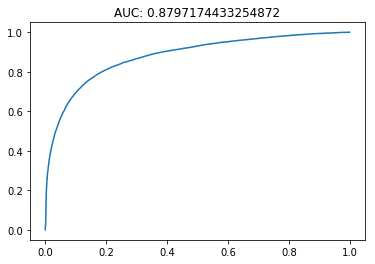

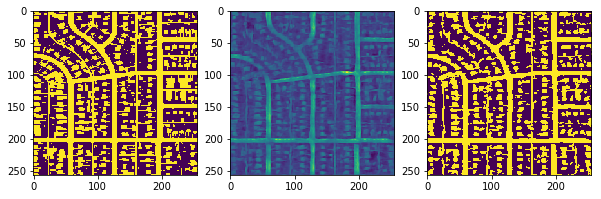

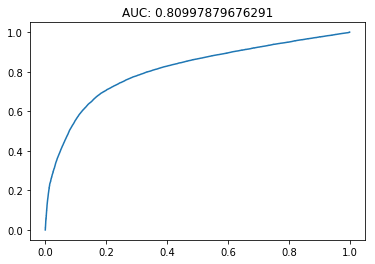

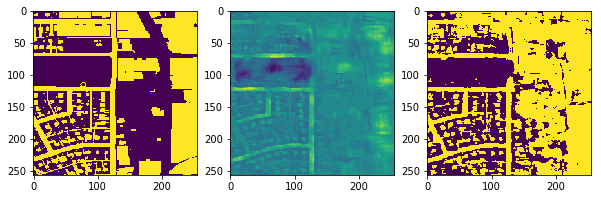

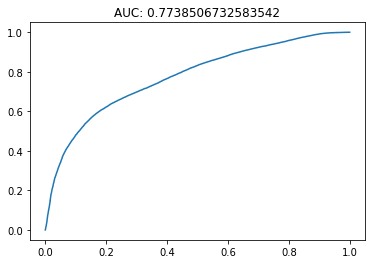

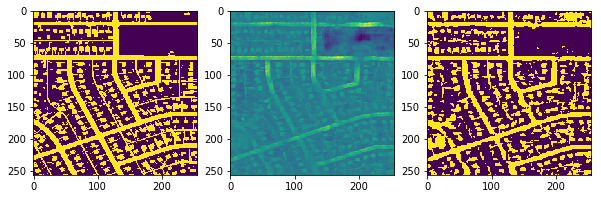

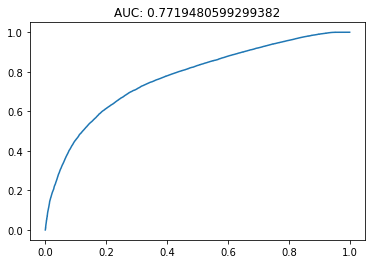

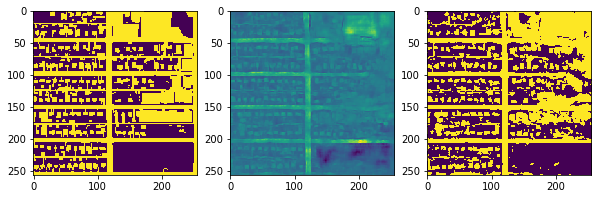

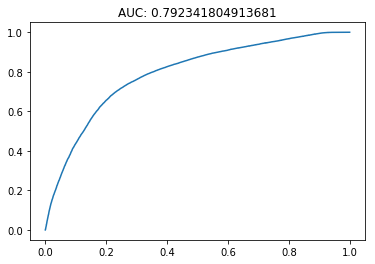

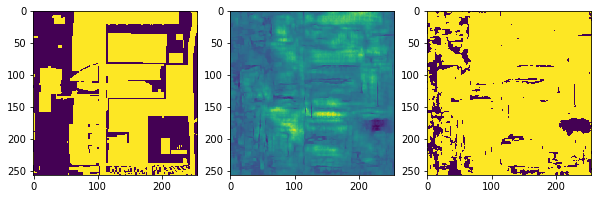

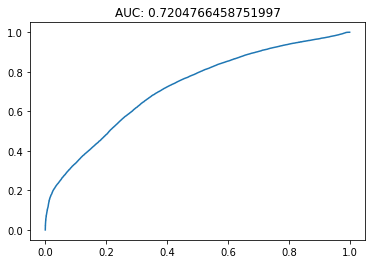

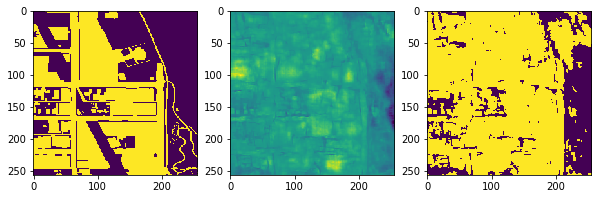

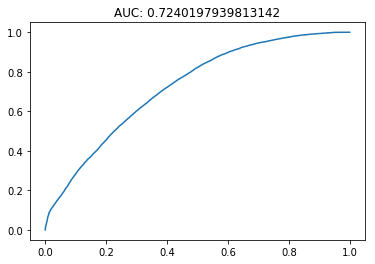

In [11]:
ps_model.eval()
for ind in range(0,50):
    fig, ax = plt.subplots(1,3, figsize=(10,5))
    test_im, test_target = ps_test_ds[ind]
    test_out = ps_model(variable(test_im.unsqueeze(0)))
    ax[0].imshow(test_target.numpy()[0])

    out = test_out.cpu().detach().numpy()[0][0]
    ax[1].imshow(out)

    ax[2].imshow(out>0)
    #ax[2].imshow(test_im.unsqueeze(0).cpu().detach().numpy()[0][0])
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_target.numpy().flatten(), out.flatten())
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate)
    plt.title('AUC: {}'.format(roc_auc))


## save the model, AUC, and loss vectors

In [12]:
save_res = True

if save_res:
    # directory
    save_dir = 'files_MS_aug_bgrn1'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    model_path = 'bgrn1_ms_aug_ep{}_step{}_b{}.pt'.format(num_epochs, ps_step, bsize)
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': ps_model.state_dict(),
            'epoch': ep,
            'step': ps_step,
        }, str(model_path))

    save(model_path)

    # save the AUCs
    auc_path = 'auc_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    auc_path = os.path.join(save_dir, auc_path)
    np.savetxt(auc_path, np.array(ps_rocs))

    #save the loss vectors
    ep_loss_path = 'losses_ep_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    ep_loss_path = os.path.join(save_dir, ep_loss_path)
    np.savetxt(ep_loss_path, np.array(ps_losses_ep))

    #save the total loss vector
    loss_path = 'loss_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    loss_path = os.path.join(save_dir, loss_path)
    np.savetxt(loss_path, np.array(ps_losses))

In [ ]:
ps_step